# 今回の取り組み

## Nanoporeに最後まで読まれなかった（途中で切断された）リードがクラスタに分かれてしまうので、これを除去したい

- これはControlにも存在するはずだが、現状ではクラスラリングの際にControlにおいて切断リードの大半が含まれるであろうSVを無視しているため、差分が効いていない

- ✅ (1) SV判定をコンセンサスコールのあとにずらす
- **(2) クラスタリングの際にSampleとControlに同様に見られる切断リードを除く**

## いつものセットアップ

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [2]:
%%bash
# pipの更新
pip install -q -U pip
pip install -q -U -r requirements.txt

# 実験

In [3]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path

from DAJIN2.core import preprocess, classification, clustering, consensus, report

#### #* 2-cut deletion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "misc/data/tyr_albino_50%.fq.gz",
    "misc/data/tyr_control.fq.gz",
    "misc/data/tyr_control.fasta",
    "single_tyr_50",
    "mm10",
    True,
    14,
)
print(f"processing {NAME}...")

##########################################################
# Check inputs
##########################################################
preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = min(THREADS, os.cpu_count()-1)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing single_tyr_50...


In [4]:

flag1 = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_control.jsonl").exists()
flag2 = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_control.jsonl").exists()
flag = flag1 and flag2

if not flag:
    print("preprocessing...")
    ################################################################################
    # Export fasta files as single-FASTA format
    ################################################################################
    for identifier, sequence in FASTA_ALLELES.items():
        contents = "\n".join([">" + identifier, sequence]) + "\n"
        output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
        output_fasta.write_text(contents)
    ###############################################################################
    # Mapping with mappy
    ###############################################################################
    for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
        name_fasta = path_fasta.stem
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
        )
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
        )
    ########################################################################
    # MIDSV conversion
    ########################################################################
    for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    ###############################################################################
    # CSSPLITS Error Correction
    ###############################################################################
    preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    preprocess.correct_knockin.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    ###############################################################################
    # Convert any `N` as deletions other than consecutive `N` from both ends
    ###############################################################################
    preprocess.replace_N_to_D.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME)
    preprocess.replace_N_to_D.execute(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
    ###############################################################################
    # Cashe inputs (control)
    ###############################################################################
    if not IS_CACHE_CONTROL:
        control_hash = Path(CONTROL).read_bytes()
        control_hash = hashlib.sha256(control_hash).hexdigest()
        PATH_CACHE_HASH = Path(TEMPDIR, "cache", "control_hash.txt")
        PATH_CACHE_HASH.write_text(str(control_hash))


In [6]:
####################################################################################
# Classify alleles
####################################################################################
print("Classify...")

classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)

# for classif in classif_sample:
#     classif["SV"] = classification.detect_sv(classif["CSSPLIT"], threshold=50)

####################################################################################
# Clustering
####################################################################################
print("Clustering...")

MUTATION_LOCI = clustering.extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)
clust_sample = clustering.clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS)
clust_sample = clustering.clustering.add_readnum(clust_sample)
clust_sample = clustering.clustering.add_percent(clust_sample)
clust_sample = clustering.clustering.update_labels(clust_sample)


Classify...
Clustering...


In [7]:
count_labels = defaultdict(int)
for clust in clust_sample:
    count_labels[clust["LABEL"]] += 1

print(count_labels)

defaultdict(<class 'int'>, {1: 3636, 2: 1364})


In [ ]:
from __future__ import annotations

from collections import defaultdict
from itertools import groupby
from pathlib import Path

import midsv

from DAJIN2.core.clustering.make_score import make_score
from DAJIN2.core.clustering.return_labels import return_labels
from DAJIN2.core.preprocess.correct_knockin import extract_knockin_loci


def compress_insertion(cssplits: list[list[str]]) -> list[dict[str, int]]:
    """Insertion will be subdivided by sequence error in the its sequence, so it is compressed as a '+I' to eliminate mutations.
    #TODO ただ、これでは、insertion配列の中に真のmutationがある場合に、そのmutationを抽出できないので、**insertion配列の中にmutationがある場合は、insertion配列をそのまま残す**必要がある。
    """
    cssplits_abstracted = []
    for cssplit in cssplits:
        for i, cs in enumerate(cssplit):
            if cs.startswith("+"):
                cssplit[i] = "+I" + cs.split("|")[-1]
        cssplits_abstracted.append(cssplit)
    return cssplits_abstracted


def extract_cssplits_in_mutation_by_3mer(cssplits_sample: list[list], mutation_loci: set) -> list[list]:
    cssplits_mutation = []
    for cssplits in cssplits_sample:
        cs_mutation = []
        for i in range(1, len(cssplits) - 1):
            if i in mutation_loci:
                kmer = ",".join([cssplits[i - 1], cssplits[i], cssplits[i + 1]])
                cs_mutation.append(kmer)
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation


# def extract_cssplits_in_mutation(cssplits_sample: list[list], mutation_loci: set) -> list[list]:
#     cssplits_mutation = []
#     for cssplits in cssplits_sample:
#         cs_mutation = []
#         for i, cs in enumerate(cssplits):
#             if i in mutation_loci:
#                 cs_mutation.append(cs)
#         cssplits_mutation.append(cs_mutation)
#     return cssplits_mutation


def annotate_score(cssplits: list[list[str]], mutation_score: list[dict[str:float]]) -> list[list[float]]:
    scores = []
    for cssplit in cssplits:
        score = []
        for cs, mutscore in zip(cssplit, mutation_score):
            if mutscore == {}:
                score.append(0)
                continue
            mutation = list(mutscore.keys())[0]
            value = list(mutscore.values())[0]
            if cs == mutation:
                score.append(value)
            else:
                score.append(0)
        scores.append(score)
    return scores


# def annotate_score(cssplits: list[list], mutation_loci: set, mutation_score: list[dict]):
#     scores = []
#     for cssplit in cssplits:
#         score = [0]
#         for i in range(1, len(cssplit) - 1):
#             if not i in mutation_loci:
#                 score.append(0)
#                 continue
#             kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
#             score.append(mutation_score[i].get(kmer, 0))
#         scores.append(score + [0])
#     return scores


def reorder_labels(labels: list[int], start: int = 0) -> list[int]:
    labels_ordered = labels.copy()
    num = start
    d = defaultdict(int)
    for i, l in enumerate(labels_ordered):
        if not d[l]:
            num += 1
            d[l] = num
        labels_ordered[i] = d[l]
    return labels_ordered


def add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS: int = 1) -> list[dict[str]]:
    knockin_alleles = extract_knockin_loci(TEMPDIR)
    labels_all = []
    max_label = 0
    classif_sample.sort(key=lambda x: x["ALLELE"])
    for allele, group in groupby(classif_sample, key=lambda x: x["ALLELE"]):
        mutation_loci: set = MUTATION_LOCI[allele]
        if mutation_loci == set():
            labels_all.extend([1] * len(classif_sample))
            continue
        knockin_loci: set = knockin_alleles[allele]
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in group]
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        # cssplits_control = replace_both_ends_n(cssplits_control)
        # cssplits_sample = replace_both_ends_n(cssplits_sample)
        cssplits_control = compress_insertion(cssplits_control)
        cssplits_sample = compress_insertion(cssplits_sample)
        cssplits_control = extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
        cssplits_sample = extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
        mutation_score = make_score(cssplits_control, cssplits_sample)
        scores_control = annotate_score(cssplits_control, mutation_score)
        scores_sample = annotate_score(cssplits_sample, mutation_score)
        labels = return_labels(scores_sample, scores_control)
        labels_reorder = reorder_labels(labels, start=max_label)
        max_label = max(labels_reorder)
        labels_all.extend(labels_reorder)
    clust_sample = classif_sample.copy()
    for clust, label in zip(clust_sample, labels_all):
        clust["LABEL"] = label
    return clust_sample


def add_readnum(clust_sample: list[dict]) -> list[dict]:
    clust_result = clust_sample.copy()
    readnum = defaultdict(int)
    for cs in clust_result:
        readnum[cs["LABEL"]] += 1
    for cs in clust_result:
        cs["READNUM"] = readnum[cs["LABEL"]]
    return clust_result


def add_percent(clust_sample: list[dict]) -> list[dict]:
    clust_result = clust_sample.copy()
    n_sample = len(clust_result)
    percent = defaultdict(int)
    for cs in clust_result:
        percent[cs["LABEL"]] += 1 / n_sample
    percent = {key: round(val * 100, 3) for key, val in percent.items()}
    for cs in clust_result:
        cs["PERCENT"] = percent[cs["LABEL"]]
    return clust_result


def update_labels(clust_sample: list[dict]) -> list[dict]:
    """
    Allocate new labels according to the ranking by PERCENT
    """
    clust_result = clust_sample.copy()
    clust_result.sort(key=lambda x: (-x["PERCENT"], x["LABEL"]))
    new_label = 1
    prev_label = clust_result[0]["LABEL"]
    for cs in clust_result:
        if prev_label != cs["LABEL"]:
            new_label += 1
        prev_label = cs["LABEL"]
        cs["LABEL"] = new_label
    return clust_result


In [40]:
import midsv
allele = "control"
mutation_loci = MUTATION_LOCI[allele]
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]

cssplits_control = compress_insertion(cssplits_control)
cssplits_sample = compress_insertion(cssplits_sample)
cssplits_control = extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
cssplits_sample = extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
mutation_score = make_score(cssplits_control, cssplits_sample)
scores_control = annotate_score(cssplits_control, mutation_score)
scores_sample = annotate_score(cssplits_sample, mutation_score)
print(len(scores_control))

10000


In [41]:
from collections import Counter
labels = return_labels(scores_sample, scores_control)
Counter(labels)

Counter({19: 2489, 1: 2417, 3: 36, 2: 58})

In [42]:
for score, label in zip(scores_sample, labels):
    if label == 3:
        print(score)
        break

[0, 49.48, 0, 0.55, 0.55, 0.55, 0.5700000000000003, 0.56, 0.56, 0.5500000000000003, 0.5500000000000003, 0.5500000000000003, 0.5500000000000003, 0.5500000000000003, 0.5500000000000003, 0.5500000000000003, 0.5500000000000003, 0.5400000000000003, 0.5400000000000003, 0.5400000000000003, 0.5400000000000003, 0.5499999999999998, 0.5499999999999998, 0.5499999999999998, 0.54, 0.56, 0.56, 0.56, 0.55, 0.55, 0.55, 0.53, 0.53, 0.53, 0.54, 0.54, 0.54, 0.54, 0.56, 0.55, 0.55, 0.54, 0.54, 0.56, 0.56, 0.55, 0.55, 0.56, 0.56, 0.55, 0.55, 0.55, 0.54, 0.54, 0.54, 0.54, 0.54, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.54, 0.53, 0.5300000000000002, 0.5300000000000002, 0.5300000000000002, 0.5300000000000002, 0.5300000000000002, 0.5300000000000002, 0.5300000000000002, 0.5300000000000002, 0.5300000000000002, 0.52, 0.52, 0.52, 0.52, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.52, 0.5299999999999998, 0.5299999999999998, 0.5299999999999998, 0.5199999999999998, 0.51999999

- 理想：断片リードにおいては、コントロールにも同じように見られるものについては無視する

- 詳しく言語化
  - 断片リードは断端から`N`が連続するものであり、NanoporeにDNAが完全に呼び込まれなかったものと考えられる
  - この断片リードは現状では`SV`と判定されるが、一般に`SV`ではない
    - もし変異部位があればあればそれは`SV`ではないと考えられる
  コントロールとサンプルには、同様に断片リードが見られると想定される

- `MUTATION_LOCI`に{ins, sub, del}のどの変異なのか情報を持たせると良さそう

In [43]:
from __future__ import annotations

from collections import defaultdict
from pathlib import Path

import midsv


def _calc_percent_indels(cssplits):
    percelt_indels = []
    cssplits_transposed = [list(t) for t in zip(*cssplits)]
    for cssplit in cssplits_transposed:
        coverage = 0
        count_indelsub = {"ins": 0, "del": 0, "sub": 0}
        for cs in cssplit:
            if cs == "N":
                continue
            coverage += 1
            if cs.startswith("+"):
                count_indelsub["ins"] += 1
            elif cs.startswith("-"):
                count_indelsub["del"] += 1
            elif cs.startswith("*"):
                count_indelsub["sub"] += 1
        if coverage == 0:
            per_indels = {"ins": 0, "del": 0, "sub": 0}
        else:
            per_indels = {mutation: (count / coverage * 100) for mutation, count in count_indelsub.items()}
        percelt_indels.append(per_indels)
    return percelt_indels


def _extract(cssplits_sample, cssplits_control) -> dict[int, str]:
    percent_sample = _calc_percent_indels(cssplits_sample)
    percent_control = _calc_percent_indels(cssplits_control)
    mutation_loci = dict()
    for i, (samp, cont) in enumerate(zip(percent_sample, percent_control)):
        for mutation_type in ["ins", "del", "sub"]:
            if abs(samp[mutation_type] - cont[mutation_type]) > 0.5:
                mutation_loci.update({i: mutation_type})
    return mutation_loci


###############################################################################


def extract_mutation_loci(TEMPDIR: Path, FASTA_ALLELES: dict, SAMPLE_NAME: str, CONTROL_NAME: str) -> defaultdict(dict):
    mutation_loci = defaultdict(dict)
    for allele in FASTA_ALLELES.keys():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        mutation_loci[allele] = _extract(cssplits_sample, cssplits_control)
    return mutation_loci


In [44]:
MUTATION_LOCI = extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)

In [45]:
print(MUTATION_LOCI)

defaultdict(<class 'dict'>, {'control': {135: 'ins', 828: 'sub', 1096: 'del', 1097: 'del', 1098: 'del', 1099: 'del', 1100: 'del', 1101: 'del', 1102: 'del', 1103: 'del', 1104: 'del', 1105: 'del', 1106: 'del', 1107: 'del', 1108: 'del', 1109: 'del', 1110: 'del', 1111: 'del', 1112: 'del', 1113: 'del', 1114: 'del', 1115: 'del', 1116: 'del', 1117: 'del', 1118: 'del', 1119: 'del', 1120: 'del', 1121: 'del', 1122: 'del', 1123: 'del', 1124: 'del', 1125: 'del', 1126: 'del', 1127: 'del', 1128: 'del', 1129: 'del', 1130: 'del', 1131: 'del', 1132: 'del', 1133: 'del', 1134: 'del', 1135: 'del', 1136: 'del', 1137: 'del', 1138: 'del', 1139: 'del', 1140: 'del', 1141: 'del', 1142: 'del', 1143: 'del', 1144: 'del', 1145: 'del', 1146: 'del', 1147: 'del', 1148: 'del', 1149: 'del', 1150: 'del', 1151: 'del', 1152: 'del', 1153: 'del', 1154: 'del', 1155: 'del', 1156: 'del', 1157: 'del', 1158: 'del', 1159: 'del', 1160: 'del', 1161: 'del', 1162: 'del', 1163: 'del', 1164: 'del', 1165: 'del', 1166: 'del', 1167: 'del',

In [47]:
mutation_loci = MUTATION_LOCI[allele]
print(mutation_loci)

{135: 'ins', 828: 'sub', 1096: 'del', 1097: 'del', 1098: 'del', 1099: 'del', 1100: 'del', 1101: 'del', 1102: 'del', 1103: 'del', 1104: 'del', 1105: 'del', 1106: 'del', 1107: 'del', 1108: 'del', 1109: 'del', 1110: 'del', 1111: 'del', 1112: 'del', 1113: 'del', 1114: 'del', 1115: 'del', 1116: 'del', 1117: 'del', 1118: 'del', 1119: 'del', 1120: 'del', 1121: 'del', 1122: 'del', 1123: 'del', 1124: 'del', 1125: 'del', 1126: 'del', 1127: 'del', 1128: 'del', 1129: 'del', 1130: 'del', 1131: 'del', 1132: 'del', 1133: 'del', 1134: 'del', 1135: 'del', 1136: 'del', 1137: 'del', 1138: 'del', 1139: 'del', 1140: 'del', 1141: 'del', 1142: 'del', 1143: 'del', 1144: 'del', 1145: 'del', 1146: 'del', 1147: 'del', 1148: 'del', 1149: 'del', 1150: 'del', 1151: 'del', 1152: 'del', 1153: 'del', 1154: 'del', 1155: 'del', 1156: 'del', 1157: 'del', 1158: 'del', 1159: 'del', 1160: 'del', 1161: 'del', 1162: 'del', 1163: 'del', 1164: 'del', 1165: 'del', 1166: 'del', 1167: 'del', 1168: 'del', 1169: 'del', 1170: 'del', 

In [56]:
def _extract_cssplits_in_mutation_by_3mer(cssplits_sample: list[list], mutation_loci: dict[int, str]) -> list[list]:
    cssplits_mutation = []
    for cssplits in cssplits_sample:
        cs_mutation = []
        for i in range(1, len(cssplits) - 1):
            if i in mutation_loci.keys():
                flag_match_mutation = False
                if cssplits[i].startswith("+") and mutation_loci[i] == "ins":
                    flag_match_mutation = True
                if cssplits[i].startswith("-") and mutation_loci[i] == "del":
                    flag_match_mutation = True
                if cssplits[i].startswith("*") and mutation_loci[i] == "sub":
                    flag_match_mutation = True
                if flag_match_mutation:
                    kmer = ",".join([cssplits[i - 1], cssplits[i], cssplits[i + 1]])
                    cs_mutation.append(kmer)
                else:
                    cs_mutation.append("")
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation



In [57]:
allele = "control"
mutation_loci = MUTATION_LOCI[allele]
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
cssplits_control = compress_insertion(cssplits_control)
cssplits_sample = compress_insertion(cssplits_sample)
cssplits_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
cssplits_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)


In [58]:
len(cssplits_sample[0])
print(cssplits_sample[3])

['', '=C,*GT,=T', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

In [61]:
print(len(cssplits_sample[0]))
print(len(cssplits_control[0]))

279
279


In [62]:
mutation_score = make_score(cssplits_control, cssplits_sample)

IndexError: list index out of range

In [64]:
from __future__ import annotations

from collections import Counter


def _call_count(cssplits: list[list[str]]) -> list[dict[str, int]]:
    count_kmer = []
    for cs in list(zip(*cssplits)):
        count_kmer.append(dict(Counter(cs)))
    return count_kmer

def _call_percent(counts: list[dict[str:int]]) -> list[dict[str:float]]:
    cssplit_percent = []
    coverage = sum(counts[0].values())
    for count in counts:
        percent = {k: v / coverage * 100 for k, v in count.items()}
        cssplit_percent.append(percent)
    return cssplit_percent


def _subtract_percentage(percent_control, percent_sample) -> list[dict]:
    sample_subtracted = []
    for cont, samp in zip(percent_control, percent_sample):
        samp = Counter(samp)
        samp.subtract(Counter(cont))
        sample_subtracted.append(dict(samp))
    return sample_subtracted

def _discard_common_error(percent_subtraction, threshold=0.5) -> list[dict]:
    percent_discarded = []
    for samp in percent_subtraction:
        remained = {k: v for k, v in samp.items() if v > threshold}
        percent_discarded.append(remained)
    return percent_discarded


def _discard_match(percent_discarded) -> list[dict]:
    mutation_score = []
    for samp in percent_discarded:
        if samp == {}:
            continue
        if "" in samp:
            continue
        if list(samp.keys())[0].split(",")[1].startswith("="):
            continue
        remained = {k: v for k, v in samp.items()}
        mutation_score.append(remained)

###############################################################################
# main
###############################################################################


def make_score(cssplits_control, cssplits_sample) -> list[dict[str, float]]:
    counts_control = _call_count(cssplits_control)
    counts_sample = _call_count(cssplits_sample)
    percent_control = _call_percent(counts_control)
    percent_sample = _call_percent(counts_sample)
    percent_subtraction = _subtract_percentage(percent_control, percent_sample)
    percent_discarded = _discard_common_error(percent_subtraction, 0.5)
    mutation_score = _discard_match(percent_discarded)
    return mutation_score


In [66]:
counts_control = _call_count(cssplits_control)
counts_sample = _call_count(cssplits_sample)
percent_control = _call_percent(counts_control)
percent_sample = _call_percent(counts_sample)
percent_subtraction = _subtract_percentage(percent_control, percent_sample)
percent_discarded = _discard_common_error(percent_subtraction, 0.5)


In [103]:
print(percent_discarded)

[{'': 0.5300000000000011}, {'=C,*GT,=T': 49.48}, {}, {'-G,-T,-T': 0.55}, {'-T,-T,-T': 0.55}, {'-T,-T,-A': 0.55}, {'-T,-A,-A': 0.5700000000000003}, {'-A,-A,-T': 0.56}, {'-A,-T,-G': 0.56}, {'-T,-G,-A': 0.5500000000000003}, {'-G,-A,-T': 0.5500000000000003}, {'-A,-T,-A': 0.5500000000000003}, {'-T,-A,-T': 0.5500000000000003}, {'-A,-T,-C': 0.5500000000000003}, {'-T,-C,-A': 0.5500000000000003}, {'-C,-A,-A': 0.5500000000000003}, {'-A,-A,-C': 0.5500000000000003}, {'-A,-C,-A': 0.5400000000000003}, {'-C,-A,-T': 0.5400000000000003}, {'-A,-T,-C': 0.5400000000000003}, {'-T,-C,-T': 0.5400000000000003}, {'-C,-T,-A': 0.5499999999999998}, {'-T,-A,-C': 0.5499999999999998}, {'-A,-C,-G': 0.5499999999999998}, {'-C,-G,-A': 0.54}, {'-G,-A,-C': 0.56}, {'-A,-C,-C': 0.56}, {'-C,-C,-T': 0.56}, {'-C,-T,-C': 0.55}, {'-T,-C,-T': 0.55}, {'-C,-T,-T': 0.55}, {'-T,-T,-T': 0.53}, {'-T,-T,-G': 0.53}, {'-T,-G,-T': 0.53}, {'-G,-T,-A': 0.54}, {'-T,-A,-T': 0.54}, {'-A,-T,-G': 0.54}, {'-T,-G,-G': 0.54}, {'-G,-G,-A': 0.56}, {'-

In [127]:
sample_discarded = []
for samp in percent_discarded:
    if samp == {}:
        continue
    if "" in samp:
        continue
    if list(samp.keys())[0].split(",")[1].startswith("="):
        continue
    remained = {k: v for k, v in samp.items()}
    sample_discarded.append(remained)

def _discard_match(percent_discarded) -> list[dict]:
    mutation_score = []
    for samp in percent_discarded:
        if samp == {}:
            score = {}
        elif "" in samp:
            score = {}
        elif list(samp.keys())[0].split(",")[1].startswith("="):
            score = {}
        else:
            score = {k: v for k, v in samp.items()}
        mutation_score.append(score)
    return mutation_score

In [128]:
counts_control = _call_count(cssplits_control)
counts_sample = _call_count(cssplits_sample)
percent_control = _call_percent(counts_control)
percent_sample = _call_percent(counts_sample)
percent_subtraction = _subtract_percentage(percent_control, percent_sample)
percent_discarded = _discard_common_error(percent_subtraction, 0.5)
mutation_score = _discard_match(percent_discarded)

In [129]:
print(len(percent_discarded))

279


In [130]:
print(len(cssplits_control[0]))
print(len(mutation_score))

279
279


In [131]:
print(mutation_score)

[{}, {'=C,*GT,=T': 49.48}, {}, {'-G,-T,-T': 0.55}, {'-T,-T,-T': 0.55}, {'-T,-T,-A': 0.55}, {'-T,-A,-A': 0.5700000000000003}, {'-A,-A,-T': 0.56}, {'-A,-T,-G': 0.56}, {'-T,-G,-A': 0.5500000000000003}, {'-G,-A,-T': 0.5500000000000003}, {'-A,-T,-A': 0.5500000000000003}, {'-T,-A,-T': 0.5500000000000003}, {'-A,-T,-C': 0.5500000000000003}, {'-T,-C,-A': 0.5500000000000003}, {'-C,-A,-A': 0.5500000000000003}, {'-A,-A,-C': 0.5500000000000003}, {'-A,-C,-A': 0.5400000000000003}, {'-C,-A,-T': 0.5400000000000003}, {'-A,-T,-C': 0.5400000000000003}, {'-T,-C,-T': 0.5400000000000003}, {'-C,-T,-A': 0.5499999999999998}, {'-T,-A,-C': 0.5499999999999998}, {'-A,-C,-G': 0.5499999999999998}, {'-C,-G,-A': 0.54}, {'-G,-A,-C': 0.56}, {'-A,-C,-C': 0.56}, {'-C,-C,-T': 0.56}, {'-C,-T,-C': 0.55}, {'-T,-C,-T': 0.55}, {'-C,-T,-T': 0.55}, {'-T,-T,-T': 0.53}, {'-T,-T,-G': 0.53}, {'-T,-G,-T': 0.53}, {'-G,-T,-A': 0.54}, {'-T,-A,-T': 0.54}, {'-A,-T,-G': 0.54}, {'-T,-G,-G': 0.54}, {'-G,-G,-A': 0.56}, {'-G,-A,-T': 0.55}, {'-A,

In [132]:
def _annotate_score(cssplits: list[list[str]], mutation_score: list[dict[str:float]]) -> list[list[float]]:
    scores = []
    for cssplit in cssplits:
        score = []
        for cs, mutscore in zip(cssplit, mutation_score):
            if mutscore == {}:
                score.append(0)
                continue
            mutation = list(mutscore.keys())[0]
            value = list(mutscore.values())[0]
            if cs == mutation:
                score.append(value)
            else:
                score.append(0)
        scores.append(score)
    return scores

scores_control = _annotate_score(cssplits_control, mutation_score)
scores_sample = _annotate_score(cssplits_sample, mutation_score)
labels = return_labels(scores_sample, scores_control)


In [133]:
Counter(labels)

Counter({19: 2489, 1: 2417, 3: 36, 2: 58})

In [134]:
for samp, label in zip(scores_sample, labels):
    if label == 3:
        print(samp)
        break

[0, 49.48, 0, 0.55, 0.55, 0.55, 0.5700000000000003, 0.56, 0.56, 0.5500000000000003, 0.5500000000000003, 0.5500000000000003, 0.5500000000000003, 0.5500000000000003, 0.5500000000000003, 0.5500000000000003, 0.5500000000000003, 0.5400000000000003, 0.5400000000000003, 0.5400000000000003, 0.5400000000000003, 0.5499999999999998, 0.5499999999999998, 0.5499999999999998, 0.54, 0.56, 0.56, 0.56, 0.55, 0.55, 0.55, 0.53, 0.53, 0.53, 0.54, 0.54, 0.54, 0.54, 0.56, 0.55, 0.55, 0.54, 0.54, 0.56, 0.56, 0.55, 0.55, 0.56, 0.56, 0.55, 0.55, 0.55, 0.54, 0.54, 0.54, 0.54, 0.54, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.54, 0.53, 0.5300000000000002, 0.5300000000000002, 0.5300000000000002, 0.5300000000000002, 0.5300000000000002, 0.5300000000000002, 0.5300000000000002, 0.5300000000000002, 0.5300000000000002, 0.52, 0.52, 0.52, 0.52, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.52, 0.5299999999999998, 0.5299999999999998, 0.5299999999999998, 0.5199999999999998, 0.51999999

In [135]:
for samp, label in zip(cssplits_sample, labels):
    if label == 3:
        print(samp)
        break

['', '=C,*GT,=T', '-T,-G,-T', '-G,-T,-T', '-T,-T,-T', '-T,-T,-A', '-T,-A,-A', '-A,-A,-T', '-A,-T,-G', '-T,-G,-A', '-G,-A,-T', '-A,-T,-A', '-T,-A,-T', '-A,-T,-C', '-T,-C,-A', '-C,-A,-A', '-A,-A,-C', '-A,-C,-A', '-C,-A,-T', '-A,-T,-C', '-T,-C,-T', '-C,-T,-A', '-T,-A,-C', '-A,-C,-G', '-C,-G,-A', '-G,-A,-C', '-A,-C,-C', '-C,-C,-T', '-C,-T,-C', '-T,-C,-T', '-C,-T,-T', '-T,-T,-T', '-T,-T,-G', '-T,-G,-T', '-G,-T,-A', '-T,-A,-T', '-A,-T,-G', '-T,-G,-G', '-G,-G,-A', '-G,-A,-T', '-A,-T,-G', '-T,-G,-C', '-G,-C,-A', '-C,-A,-T', '-A,-T,-T', '-T,-T,-A', '-T,-A,-C', '-A,-C,-T', '-C,-T,-A', '-T,-A,-T', '-A,-T,-G', '-T,-G,-T', '-G,-T,-G', '-T,-G,-T', '-G,-T,-C', '-T,-C,-A', '-C,-A,-A', '-A,-A,-G', '-A,-G,-G', '-G,-G,-G', '-G,-G,-A', '-G,-A,-C', '-A,-C,-A', '-C,-A,-C', '-A,-C,-A', '-C,-A,-C', '-A,-C,-T', '-C,-T,-G', '-T,-G,-C', '-G,-C,-T', '-C,-T,-T', '-T,-T,-G', '-T,-G,-G', '-G,-G,-G', '-G,-G,-G', '-G,-G,-G', '-G,-G,-C', '-G,-C,-T', '-C,-T,-C', '-T,-C,-T', '-C,-T,-G', '-T,-G,-A', '-G,-A,-A', '-A,-A,-A'

- なぜか連続したNが欠失になっている…
- これは`preprocess.replace_N_to_D`の問題かもしれません

In [140]:
for samp, label in zip(midsv_sample, labels):
    if label == 3:
        print(samp["QNAME"])
        print(samp["CSSPLIT"])
        break

03f31ef7-f592-4a0b-9840-3d5bc6ea9b40
=T,=G,=C,=A,=T,=T,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,=A,=C,=C,=A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=G,=A,=T,=A,=T,=C,=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,=A,=A,=A,=A,=A,=T,=G,=A,=G,=A,=G,=G,=C,=A,=A,=C,=T,=A,=T,=T,=T,=T,=A,=G,=A,=C,=T,=G,=A,=T,=T,=A,=C,=T,=T,=T,=T,=A,=T,=A,=A,=A,=A,=T,=A,=A,=A,=T,=A,=A,=G,=C,=T,=C,=A,=G,=C,=T,=T,=A,=G,=C,=C,=A,=G,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,=T,=C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,=C,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,=T,=A,=T,=A,=A,=A,=T,=G,=T,=T,=A,=T,=T,=G,=T,=C,=T,=A,=C,=T,=T,=A,=T,=G,=A,=T,=C,=T,=C,=T,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,=T,=C,=A,=T,=G,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,=A,=T,=G,=T,=A,=T,=T,=C,=T,=T,=G,=A,=T,=A,=C,=T,=A,=C,=T,=T,=C,=T,=C,=A,=T,=T,=T,=G,=C,=A,=A,=A,=T,=T,=C,=C,=A,

- きちんと断片リードの`N`は`N`のままなので、`preprocess.replace_N_to_D`の問題ではありませんでした…

In [138]:
allele = "control"
mutation_loci = MUTATION_LOCI[allele]
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
cssplits_control = compress_insertion(cssplits_control)
cssplits_sample = compress_insertion(cssplits_sample)
# cssplits_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
# cssplits_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)


In [139]:
for samp, label in zip(cssplits_sample, labels):
    if label == 3:
        print(samp)
        break

['=T', '=G', '=C', '=A', '=T', '=T', '=G', '=A', '=A', '=G', '=C', '=A', '=G', '=T', '=T', '=C', '=A', '=C', '=C', '=A', '=A', '=A', '=A', '=T', '=A', '=A', '=C', '=A', '=A', '=A', '=G', '=T', '=A', '=A', '=C', '=A', '=A', '=A', '=G', '=T', '=A', '=A', '=G', '=A', '=T', '=A', '=T', '=C', '=T', '=T', '=T', '=G', '=G', '=A', '=A', '=T', '=A', '=A', '=T', '=C', '=A', '=A', '=T', '=T', '=C', '=A', '=A', '=G', '=A', '=T', '=A', '=A', '=T', '=C', '=A', '=A', '=G', '=G', '=A', '=A', '=A', '=A', '=A', '=T', '=G', '=A', '=G', '=A', '=G', '=G', '=C', '=A', '=A', '=C', '=T', '=A', '=T', '=T', '=T', '=T', '=A', '=G', '=A', '=C', '=T', '=G', '=A', '=T', '=T', '=A', '=C', '=T', '=T', '=T', '=T', '=A', '=T', '=A', '=A', '=A', '=A', '=T', '=A', '=A', '=A', '=T', '=A', '=A', '=G', '=C', '=T', '=C', '=A', '=G', '=C', '=T', '=T', '=A', '=G', '=C', '=C', '=A', '=G', '=A', '=T', '=A', '=T', '=A', '=A', '=G', '=C', '=A', '=A', '=T', '=A', '=T', '=T', '=C', '=T', '=G', '=A', '=G', '=T', '=T', '=C', '=T', '=G

- 右側の`N`のすぐ左に欠失が続くのは変な感じがします。
- midsvの問題かもしれません
- `3d5bc6ea9b40`を調べてみます

In [142]:
%%bash
cat DAJINResults/.tempdir/single_tyr_50/sam/tyr_albino_50%_splice_control.sam | grep -e "^@" -e "3d5bc6ea9b40" | samtools sort > tmp.bam
samtools index tmp.bam

- 800塩基のみの断片リードのようです
- `N`の左に欠失がくる妥当な理由はなさそうです

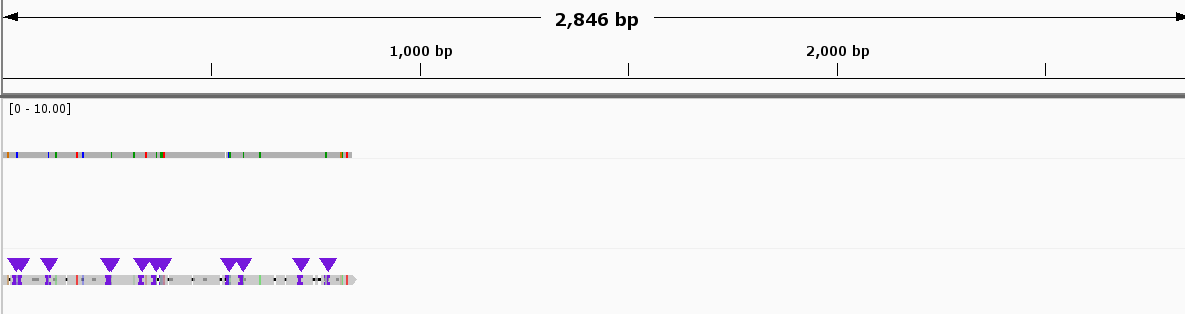

In [143]:
%%bash
cat DAJINResults/.tempdir/single_tyr_50/sam/tyr_albino_50%_splice_control.sam | grep -e "^@" -e "3d5bc6ea9b40" > tmp.sam

In [145]:
import midsv

sam = midsv.read_sam("tmp.sam")

x = midsv.transform(sam, midsv = False)

In [150]:
print(x[0]["CSSPLIT"])
print(x[0]["CSSPLIT"].count("N"))

=T,=G,=C,=A,=T,=T,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,*AG,=C,-C,-A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,=A,=A,=A,+A|+T|=G,*TC,=A,=A,=G,=A,=T,=A,=T,=C,+T|=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,-A,=A,=A,=A,=A,=T,=G,=A,-G,=A,=G,=G,=C,=A,=A,=C,=T,=A,=T,=T,=T,=T,=A,=G,=A,=C,=T,=G,=A,=T,=T,=A,=C,=T,=T,=T,*TC,=A,+C|=T,=A,=A,=A,=A,=T,=A,=A,=A,=T,=A,=A,-G,-C,*TA,=C,=A,=G,=C,=T,=T,=A,=G,=C,=C,=A,=G,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,-T,-C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,*CT,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,-T,-A,=T,*AC,=A,=A,=T,=G,=T,=T,=A,=T,=T,=G,=T,=C,=T,=A,=C,=T,=T,=A,=T,=G,=A,=T,=C,=T,-C,=T,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,=T,=C,=A,+C|=T,+A|+A|*GA,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,=A,=T,=G,=T,=A,=T,=T,=C,=T,=T,=G,=A,=T,=A,=C,=T,=A,=C,=T,=T,=C,=T,=C,=A,=T,=T,=T,=G,=C,=A,=A,=A,=T,=T,=C,*CA,=A,=A,=T,=T

- `midsv.transform`には問題がなさそうです
### `preprocess`のどこかに原因があります

In [151]:
for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
    preprocess.call_midsv(TEMPDIR, path_sam)

In [152]:
%%bash
cat DAJINResults/.tempdir/single_tyr_50/midsv/tyr_albino_50%_splice_control.jsonl | grep "3d5bc6ea9b40"

{"QNAME": "03f31ef7-f592-4a0b-9840-3d5bc6ea9b40", "RNAME": "control", "CSSPLIT": "=T,=G,=C,=A,=T,=T,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,*AG,=C,-C,-A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,=A,=A,=A,+A|+T|=G,*TC,=A,=A,=G,=A,=T,=A,=T,=C,+T|=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,-A,=A,=A,=A,=A,=T,=G,=A,-G,=A,=G,=G,=C,=A,=A,=C,=T,=A,=T,=T,=T,=T,=A,=G,=A,=C,=T,=G,=A,=T,=T,=A,=C,=T,=T,=T,*TC,=A,+C|=T,=A,=A,=A,=A,=T,=A,=A,=A,=T,=A,=A,-G,-C,*TA,=C,=A,=G,=C,=T,=T,=A,=G,=C,=C,=A,=G,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,-T,-C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,*CT,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,-T,-A,=T,*AC,=A,=A,=T,=G,=T,=T,=A,=T,=T,=G,=T,=C,=T,=A,=C,=T,=T,=A,=T,=G,=A,=T,=C,=T,-C,=T,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,=T,=C,=A,+C|=T,+A|+A|*GA,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,=A,=T,=G,=T,=A,=T,=T,=C,=T,=T,=G,=A,=T

In [153]:
preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)


In [154]:
%%bash
cat DAJINResults/.tempdir/single_tyr_50/midsv/tyr_albino_50%_splice_control.jsonl | grep "3d5bc6ea9b40"

{"QNAME": "03f31ef7-f592-4a0b-9840-3d5bc6ea9b40", "RNAME": "control", "CSSPLIT": "=T,=G,=C,=A,=T,=T,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,=A,=C,=C,=A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=G,=A,=T,=A,=T,=C,=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,=A,=A,=A,=A,=A,=T,=G,=A,=G,=A,=G,=G,=C,=A,=A,=C,=T,=A,=T,=T,=T,=T,=A,=G,=A,=C,=T,=G,=A,=T,=T,=A,=C,=T,=T,=T,=T,=A,=T,=A,=A,=A,=A,=T,=A,=A,=A,=T,=A,=A,=G,=C,=T,=C,=A,=G,=C,=T,=T,=A,=G,=C,=C,=A,=G,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,=T,=C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,=C,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,=T,=A,=T,=A,=A,=A,=T,=G,=T,=T,=A,=T,=T,=G,=T,=C,=T,=A,=C,=T,=T,=A,=T,=G,=A,=T,=C,=T,=C,=T,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,=T,=C,=A,=T,=G,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,=A,=T,=G,=T,=A,=T,=T,=C,=T,=T,=G,=A,=T,=A,=C,=T,=A,=C,=T,=T,=C,=T,

In [155]:
preprocess.correct_knockin.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)


In [156]:
%%bash
cat DAJINResults/.tempdir/single_tyr_50/midsv/tyr_albino_50%_splice_control.jsonl | grep "3d5bc6ea9b40"

{"QNAME": "03f31ef7-f592-4a0b-9840-3d5bc6ea9b40", "RNAME": "control", "CSSPLIT": "=T,=G,=C,=A,=T,=T,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,=A,=C,=C,=A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=G,=A,=T,=A,=T,=C,=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,=A,=A,=A,=A,=A,=T,=G,=A,=G,=A,=G,=G,=C,=A,=A,=C,=T,=A,=T,=T,=T,=T,=A,=G,=A,=C,=T,=G,=A,=T,=T,=A,=C,=T,=T,=T,=T,=A,=T,=A,=A,=A,=A,=T,=A,=A,=A,=T,=A,=A,=G,=C,=T,=C,=A,=G,=C,=T,=T,=A,=G,=C,=C,=A,=G,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,=T,=C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,=C,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,=T,=A,=T,=A,=A,=A,=T,=G,=T,=T,=A,=T,=T,=G,=T,=C,=T,=A,=C,=T,=T,=A,=T,=G,=A,=T,=C,=T,=C,=T,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,=T,=C,=A,=T,=G,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,=A,=T,=G,=T,=A,=T,=T,=C,=T,=T,=G,=A,=T,=A,=C,=T,=A,=C,=T,=T,=C,=T,

In [157]:
preprocess.replace_NtoD.execute(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)

In [158]:
%%bash
cat DAJINResults/.tempdir/single_tyr_50/midsv/tyr_albino_50%_splice_control.jsonl | grep "3d5bc6ea9b40"

{"QNAME": "03f31ef7-f592-4a0b-9840-3d5bc6ea9b40", "RNAME": "control", "CSSPLIT": "=T,=G,=C,=A,=T,=T,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,=A,=C,=C,=A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=G,=A,=T,=A,=T,=C,=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,=A,=A,=A,=A,=A,=T,=G,=A,=G,=A,=G,=G,=C,=A,=A,=C,=T,=A,=T,=T,=T,=T,=A,=G,=A,=C,=T,=G,=A,=T,=T,=A,=C,=T,=T,=T,=T,=A,=T,=A,=A,=A,=A,=T,=A,=A,=A,=T,=A,=A,=G,=C,=T,=C,=A,=G,=C,=T,=T,=A,=G,=C,=C,=A,=G,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,=T,=C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,=C,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,=T,=A,=T,=A,=A,=A,=T,=G,=T,=T,=A,=T,=T,=G,=T,=C,=T,=A,=C,=T,=T,=A,=T,=G,=A,=T,=C,=T,=C,=T,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,=T,=C,=A,=T,=G,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,=A,=T,=G,=T,=A,=T,=T,=C,=T,=T,=G,=A,=T,=A,=C,=T,=A,=C,=T,=T,=C,=T,

### `preprocess.replace_N_to_D.execute`が悪さをしているようです

In [8]:
for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
    preprocess.call_midsv(TEMPDIR, path_sam)

In [9]:
import midsv
midsv_sample = midsv.read_jsonl("DAJINResults/.tempdir/single_tyr_50/midsv/tyr_albino_50%_splice_control.jsonl")
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]

In [10]:
for i,samp in enumerate(midsv_sample):
    if "3d5bc6ea9b40" in samp["QNAME"]:
        print(i)

66


In [11]:
i, cssplits = 66, cssplits_sample[66]

In [12]:
flag_n_start = True
flag_n_end = True
for j, (start, end) in enumerate(zip(cssplits, cssplits[::-1])):
    print(j, start, end,flag_n_start, flag_n_end)
    if j == (len(cssplits) + 1) // 2:
        break
    if flag_n_start and start != "N":
        flag_n_start = False
    if flag_n_end and end != "N":
        flag_n_end = False
    if not (flag_n_start or True):
        break
        # if not flag_n_start and start == "N":
        #     cssplits_replaced[i][j] = f"-{sequence[j]}"
        # if not flag_n_end and end == "N":
        #     j_inv = len(cssplits) - j - 1
        #     cssplits_replaced[i][j_inv] = f"-{sequence[j_inv]}"


0 =T N True True
1 =G N False True
2 =C N False True
3 =A N False True
4 =T N False True
5 =T N False True
6 =G N False True
7 =A N False True
8 =A N False True
9 =G N False True
10 =C N False True
11 =A N False True
12 =G N False True
13 =T N False True
14 =T N False True
15 =C N False True
16 *AG N False True
17 =C N False True
18 -C N False True
19 -A N False True
20 =A N False True
21 =A N False True
22 =A N False True
23 =T N False True
24 =A N False True
25 =A N False True
26 =C N False True
27 =A N False True
28 =A N False True
29 =A N False True
30 =G N False True
31 =T N False True
32 =A N False True
33 =A N False True
34 =C N False True
35 =A N False True
36 =A N False True
37 =A N False True
38 +A|+T|=G N False True
39 *TC N False True
40 =A N False True
41 =A N False True
42 =G N False True
43 =A N False True
44 =T N False True
45 =A N False True
46 =T N False True
47 =C N False True
48 +T|=T N False True
49 =T N False True
50 =T N False True
51 =G N False True
52 =G N Fals

- 上のコードでは、半分以上Nが合った場合にバグが発生します
- 両端から連続する`N`がどこまで続くのかをインデックスで持っていき、両端のインデックスの内側にある`N`を欠失に置換するアルゴリズムが良さそうです

In [21]:
import re
cs = "".join(cssplits)
re.match("^N+", cs)
print(re.search("N+N$", cs))

<re.Match object; span=(1751, 3756), match='NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN>


In [23]:
right_idx_n = 0
for cs in cssplits:
    if cs != "N":
        break
    right_idx_n += 1

left_idx_n = 0
for cs in cssplits[::-1]:
    if cs != "N":
        break
    left_idx_n += 1

sequence = FASTA_ALLELES["control"]

for cs, seq in zip(cssplits[right_idx_n: left_idx_n], sequence[right_idx_n: left_idx_n]):
    if cs == "N":
        cs = f"-{seq}"

# print(right_idx_n, left_idx_n)


0 2005


In [51]:
def _replaceNtoD(cssplits_sample, sequence):
    cssplits_replaced = cssplits_sample.copy()
    for i, cssplits in enumerate(cssplits_sample):
        # extract right/left index of the end of sequential Ns
        right_idx_n = 0
        for cs in cssplits:
            if cs != "N":
                break
            right_idx_n += 1
        left_idx_n = 0
        for cs in cssplits[::-1]:
            if cs != "N":
                break
            left_idx_n += 1
        left_idx_n = len(cssplits) - left_idx_n - 1
        for j, (cs, seq) in enumerate(zip(cssplits, sequence)):
            if j < right_idx_n or j > left_idx_n:
                continue
            if cs == "N":
                cssplits_replaced[i][j] = f"-{seq}"
    return cssplits_replaced


In [52]:
import midsv
midsv_sample = midsv.read_jsonl("DAJINResults/.tempdir/single_tyr_50/midsv/tyr_albino_50%_splice_control.jsonl")
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
i, cssplits = 66, cssplits_sample[66]

In [53]:
right_idx_n = 0
for cs in cssplits:
    if cs != "N":
        break
    right_idx_n += 1
left_idx_n = 0
for cs in cssplits[::-1]:
    if cs != "N":
        break
    left_idx_n += 1
left_idx_n = len(cssplits) - left_idx_n - 1
for j, (cs, seq) in enumerate(zip(cssplits, sequence)):
    if j < right_idx_n or j > left_idx_n:
        continue
    if cs == "N":
        print(j)
print(right_idx_n, left_idx_n)

0 839


In [54]:
import midsv
midsv_sample = midsv.read_jsonl("DAJINResults/.tempdir/single_tyr_50/midsv/tyr_albino_50%_splice_control.jsonl")
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
sequence = FASTA_ALLELES["control"]
cssplits_sample = _replaceNtoD(cssplits_sample, sequence)

In [55]:
"".join(cssplits_sample[66]).count("N")

2005

In [57]:
print("".join(cssplits_sample[66]))

=T=G=C=A=T=T=G=A=A=G=C=A=G=T=T=C*AG=C-C-A=A=A=A=T=A=A=C=A=A=A=G=T=A=A=C=A=A=A+A|+T|=G*TC=A=A=G=A=T=A=T=C+T|=T=T=T=G=G=A=A=T=A=A=T=C=A=A=T=T=C=A=A=G=A=T=A=A=T=C=A=A=G=G-A=A=A=A=A=T=G=A-G=A=G=G=C=A=A=C=T=A=T=T=T=T=A=G=A=C=T=G=A=T=T=A=C=T=T=T*TC=A+C|=T=A=A=A=A=T=A=A=A=T=A=A-G-C*TA=C=A=G=C=T=T=A=G=C=C=A=G=A=T=A=T=A=A=G=C=A=A=T=A=T-T-C=T=G=A=G=T=T=C=T=G=A=A=G=A=A=A=A=A=T=T=T=T=T=G=A*CT=A=A=A=A=T=G=A=G=T=T=C-T-A=T*AC=A=A=T=G=T=T=A=T=T=G=T=C=T=A=C=T=T=A=T=G=A=T=C=T-C=T=A=A=A=T=A=C=A=A=C=A=G=G=C=T=T=G=T=A=T=T=C=A=G=A=A=T=C=T=A=G=A=T=G=T=T=T=C=A+C|=T+A|+A|*GA=A=C=C=T=T=T=A=T=T=C=A=T=A=A=G=A=G=A=T=G=A=T=G=T=A=T=T=C=T=T=G=A=T=A=C=T=A=C=T=T=C=T=C=A=T=T=T=G=C=A=A=A=T=T=C*CA=A=A=T=T=A=T=T=A=T=T=A=A=T=T=T=C=A=T=A=T+C|=C=A=A=T=T=A*GA=A*AT=T=A=A=T=A=T=A=T=C=T=T=C=C=T=T=C=A=A=T=T=T+G|=A*GA=T=T-A-C=C=T=C=A=C=T=A=T*GA=G*GA=C+T|+G|=T*AC=T*GT=T=A=C=A=A=A=C=T-C=C=A=A=G-A-A=A=A=A=G=T=T=A=G=T=C=A=T=G=T=G=C=T=T=T=G=C=A=G=A=A=G=A=T=A=A=A=A=G=C=T=T=A=G=T=G=T=A=A=A=A=C=A=G=G=C=T-G-A=G=A=G=T=A=T=T=T=G=A=T=G=T=A=A=G

- `preprocess.replaceNtoD`にバグがあり、修正しました！
- これでClusteringに良い影響があるといいのですが…
- 長くなったのでclusteringは次回にします

# 👉👉👉 いまここ 👈👈👈

# 👌👌👌 まとめ 👌👌👌


- `clustering`で現れるSVを調査していたところ、


# 次に取り組むこと

### Lists

- **Tyr 50% において、おそらくControlにもある断端リードが`SV`判定をされているのは消去したいところです**

+ ⬜ 断端リードの扱いをどうするべきか
+ ✅ `SV`の判定をconsensus callのあとにする
+ ⬜ Insertionのなかにある変異を同定する手法を考案する
+ ⬜ Ayabe-taks1のright_loxpがいまいちな理由を考察する
> + ⬜ cis変異の両端が欠失している場合に、Nで置き換えるとtransとなってしまうのをどうするか（`clustering.replace_both_ends_n`）
> + ⬜ `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする